In [1]:
# Ignore this cell -- this is just for plotting

import graphviz

def plot(automaton, final_state):
    dot = graphviz.Digraph()
    dot.attr(rankdir='LR', concentrate="true") 
    nodes = {a for a,_ in automaton.keys()}.union({a for to in automaton.values() for a in to})
    for n in nodes:
        if n == final_state:
            dot.node("s"+str(n),shape = "doublecircle")
        else:
            dot.node("s"+str(n),shape = "circle")
        
    for (outgoing, label), incomings in automaton.items():
        for i in incomings:
            dot.edge("s"+str(outgoing), "s"+str(i), label=label)
    return dot

In [2]:
def read_row(row):
    springs, patch_string = row.split(" ")
    return springs, [int(n) for n in patch_string.split(",")]

with open("test_input_1.txt") as fin:
    rows = [read_row(row) for row in fin]

For the solution of this task, we implement a [non-deterministic finite automaton (NFA)](https://en.wikipedia.org/wiki/Nondeterministic_finite_automaton). That encodes the following idea: Given a patch of numbers $[1,3,1,1]$, the line must follow a certain pattern:
1. A (possibly empty) sequence of operable springs (i.e. "?" or ".")
2. A single broken spring (i.e. "?" or "#") 
3. A (non-empty) sequence of operable spring (i.e. "?" or "."). 
4. A sequence of three broken springs (i.e. "?" or "#") 
5. A (non-empty) sequence of operable spring (i.e. "?" or ".").
6. A single broken spring (i.e. "?" or "#") 
7. A (non-empty) sequence of operable spring (i.e. "?" or "."). 
8. A single broken spring (i.e. "?" or "#") 
9. A (possibly empty) sequence of operable springs (i.e. "?" or ".")

In [3]:
 def patch_to_automaton(patches):
    transitions = []
    s = 0
    transitions += [(s,".", s), (s,"?", s)] # A (possibly empty) sequence of operable springs (i.e. "?" or ".")
    
    for i, p in enumerate(patches): 
        for _ in range(p): # A sequence of broken springs (i.e. "?" or "#") of length |p|
            transitions += [(s,"?", s+1), (s,"#", s+1)] 
            s+=1
        if i < len(patches)-1: # If there are more patches: A (non-empty) sequence of operable spring (i.e. "?" or ".").
            transitions += [(s,"?", s+1), (s,".", s+1)]
            s+=1
        transitions += [(s,"?", s), (s,".", s)] # A (possibly empty) sequence of operable springs (i.e. "?" or ".")
    pairs = {(a,b) for (a,b,_) in transitions}
    return {(a,b):[c for (x,y,c) in transitions if x==a and y==b] for a,b in pairs}, s

Here is the automaton for the input line `?###???????? 3,2,1`:

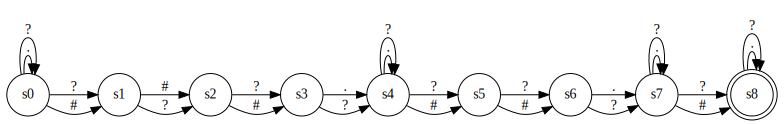

In [4]:
example_transitions, example_final_state = patch_to_automaton([3,2,1])
example_string = "?###????????"

plot(example_transitions, example_final_state)

In [5]:
def apply_transition(character, states, transitions):
    reachable = [(t,i) for s,i in states for t in transitions.get((s, character), set())]
    new_states = {s for s,_ in reachable}
    return {(s, sum(a for t,a in reachable if s == t)) for s in new_states}

At each step, we are in a set of states $S$. Initially, the state contains just the initial state, i.e.: $S=\{s_0\}$. Then we calculate the next set of states by applying the transition function on every state in $S$. In our example, the first character we process a "?". Looking at the graph, we see that the machine may move from $s_0$ to $s_1$ or remain in $s_0$. Therefore, the next state is $S'=\{s_0,s_1\}$. At the same time, we track how many possible paths through the machine we have encountered up until this point. There is only one way to get to the starting point. We initialize the path number at the start with $1$.

In [6]:
s0 = (0,1) # There is one (1) to get to the starting state (0)
new_states = apply_transition("?", {s0}, example_transitions)
print(new_states)

{(0, 1), (1, 1)}


We continue this process for the remainder of our input string:

In [7]:
for c in example_string[1:]:
    new_states = apply_transition(c, new_states, example_transitions)
    print(new_states)

{(1, 1), (2, 1)}
{(3, 1), (2, 1)}
{(3, 1)}
{(4, 1)}
{(4, 1), (5, 1)}
{(6, 1), (4, 1), (5, 1)}
{(6, 1), (4, 1), (5, 1), (7, 1)}
{(8, 1), (6, 1), (5, 1), (7, 2), (4, 1)}
{(6, 1), (5, 1), (7, 3), (8, 3), (4, 1)}
{(7, 4), (6, 1), (5, 1), (8, 6), (4, 1)}
{(6, 1), (8, 10), (5, 1), (7, 5), (4, 1)}


Now that the machine is done, we see that there was a single way to reach states 4,5, and 6, five ways to reach state 5 and ten ways to reach our final state. We are only interested in those paths, that would lead to the final node. Therefore, the solution is 10.

In [8]:
def run_automaton(string, transitions, final_state):
    states = {(0,1)}
    for char in string:
        states = apply_transition(char,states, transitions)  
    result = sum(a for s,a in states if s == final_state)
    return result

run_automaton(example_string, example_transitions, example_final_state)

10

In [9]:
def get_solutions(rows):
    for string, patches in rows:
        transitions, final_state = patch_to_automaton(patches)
        yield run_automaton(string, transitions, final_state)

In [10]:
print(sum(get_solutions(rows)))

21


## Part 2

For part two, we just need to alter the input

In [11]:
def read_row2(row):
    springs, patch_string = row.split(" ")
    return "?".join([springs for _ in range(5)]), [int(n) for _ in range(5) for n in patch_string.split(",")]

with open("test_input_1.txt") as fin:
    rows = [read_row2(row) for row in fin]
    
print(sum(get_solutions(rows)))

525152
